In [1]:
import cv2

In [2]:
image = cv2.imread('chest_xray/train/NORMAL/NORMAL-1003233-0001.jpeg')

In [ ]:
cv2.imshow("Image",image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm

In [3]:
class_name = ['NORMAL', 'PNEUMONIA']
data_path = 'chest_xray'

### Data Exploration

In [4]:
def get_list_files(dirName):
    files_list = os.listdir(dirName)
    return files_list
    

In [5]:
files_list_normal_train = get_list_files(f'{data_path}/train/{class_name[0]}')
files_list_pneu_train = get_list_files(f'{data_path}/train/{class_name[1]}')

files_list_normal_test = get_list_files(f'{data_path}/test/{class_name[0]}')
files_list_pneu_test = get_list_files(f'{data_path}/test/{class_name[1]}')

print(f'Number of train samples in Normal {len(files_list_normal_train)}')
print(f'Number of train samples in pneumonia {len(files_list_pneu_train)}')
print(f'Number of test samples in Normal {len(files_list_normal_test)}')
print(f'Number of test samples in pneumonia {len(files_list_pneu_test)}')

Number of train samples in Normal 1349
Number of train samples in pneumonia 3883
Number of test samples in Normal 234
Number of test samples in pneumonia 390


In [6]:
rand_img_no = np.random.randint(0, len(files_list_normal_train))
img = f'{data_path}/train/NORMAL/{files_list_normal_train[rand_img_no]}'

print(plt.imread(img).shape)

(1090, 1350)


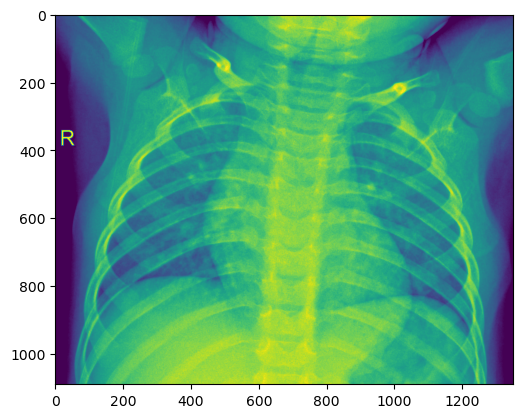

In [7]:
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

In [8]:
rand_img_no = np.random.randint(0, len(files_list_normal_train))
img = f'{data_path}/train/PNEUMONIA/{files_list_pneu_train[rand_img_no]}'

print(plt.imread(img).shape)

(800, 1016)


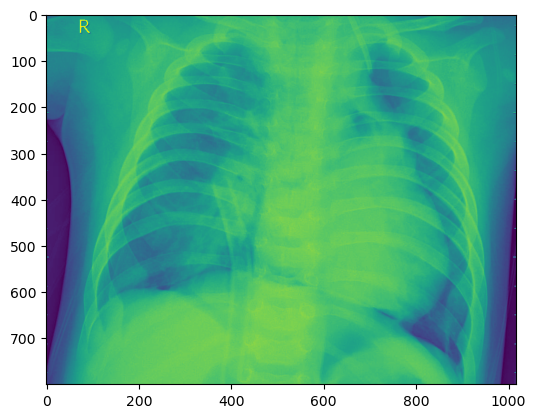

In [9]:
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

### Data Loader

In [11]:
train_transform = transforms.Compose([
      transforms.Resize(224),
      transforms.CenterCrop(224),
      #data augmentation
      transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
      transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [12]:
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform = train_transform)

test_data = datasets.ImageFolder(os.path.join(data_path,'test'), transform = test_transform)

In [13]:
train_loader = DataLoader(train_data, batch_size = 16, shuffle=True, pin_memory = True)

test_loader = DataLoader(test_data, batch_size=1, shuffle= True, pin_memory=True)

In [14]:
class_names = train_data.classes

In [15]:
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


### Model

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #input block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        #(W-F+2P)/S + 1
        #(224-3) + 1 = 222
        #out-channels = 8
        self.pool11 = nn.MaxPool2d(kernel_size = 2, stride=2)
        #(W-F+2P)/S + 1
        #(222-3)/2 + 1 = 111

        # CONVOLUTION BLOCK
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16,kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        #(W-F+2P)/S + 1
        #(111-3)+1 = 109 
        
        # TRANSITION BLOCK
        self.pool22 = nn.MaxPool2d(2,2)
        #(W-F+2P)/S + 1
        #(109-2)/2 + 1 = 54

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
            
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        #just reduces no of channels

        self.pool33 = nn.MaxPool2d(2,2)
        #(W-F+2P)/S + 1
        #(54-2)/2+1 = 27

        # CONVOLUTION BLOCK
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        #(W-F+2P)/S + 1
        #(27-3)+1 = 25

        self.convblock5 = nn.Sequential(
             nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1,1), padding=0, bias=False),
             #nn.BatchNorm2d(32)
             nn.ReLU(),
             nn.BatchNorm2d(32)
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1,1), padding=0, bias= False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        #(W-F+2P)/S + 1
        #(25-3)+1 = 23
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1,1), padding=0, bias=False),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
        )

        self.convblock10 = nn.Sequential(
             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(10)
        )
        #(W-F+2P)/S + 1
        #(23-3)+1 = 21
        
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        
        )
         #(W-F+2P)/S + 1
         #(21-3)+1 = 19
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
             nn.AvgPool2d(kernel_size=4)
        )
        #(W-F+2P)/S + 1
        #4 - since the stride will default to kernel_size

        self.convblockout = nn.Sequential(
             nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4,4), padding=0, bias=False),
        )
        #(W-F+2P)/S + 1
        #(4-4) + 1 = 1
    def forward(self,x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
    
        x = x.view(-1,2)
        return F.log_softmax(x, dim=-1)

In [19]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
summary(model, input_size=(3,224,224))

Available processor cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
       BatchNorm2d-3          [-1, 8, 222, 222]              16
         MaxPool2d-4          [-1, 8, 111, 111]               0
            Conv2d-5         [-1, 16, 109, 109]           1,152
              ReLU-6         [-1, 16, 109, 109]               0
       BatchNorm2d-7         [-1, 16, 109, 109]              32
         MaxPool2d-8           [-1, 16, 54, 54]               0
            Conv2d-9           [-1, 10, 54, 54]             160
             ReLU-10           [-1, 10, 54, 54]               0
      BatchNorm2d-11           [-1, 10, 54, 54]              20
        MaxPool2d-12           [-1, 10, 27, 27]               0
           Conv2d-13           [-1, 10, 25, 25]             900
             Re

In [20]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    lambda1 = 0.01 
    for batch_idx, (data, target) in enumerate(pbar):
        #get data
        data, target = data.to(device), target.to(device)

        #init gradient
        optimizer.zero_grad()
        #prediction
        y_pred = model(data)
        #loss
        loss = F.nll_loss(y_pred, target)
        l1 = 0
        for p in model.parameters():
            l1 = l1+p.abs().sum()
        loss = loss + lambda1*l1
        train_losses.append(loss)
        #backprop
        loss.backward()
        optimizer.step()
        #get the max log-probability index
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        accuracy = correct / processed if processed > 0 else 0 
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100 * accuracy:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{}({:.2f})\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)
    ))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('Current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH: 0


Loss=4.673332214355469 Batch_id=61 Accuracy=83.17:  19%|▏| 62/327 [01:59<08:25, 

In [ ]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_accuracies]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_accuracies]

fig, axs = plt.subplots(2,2, figsize=(16,10))
axs[0,0].plot(train_losses1, color='green')
axs[0,0].set_title("Training loss")
axs[1,0].plot(train_acc1, color='green')
axs[1,0].set_title("Training Accuracy")
axs[0,1].plot(test_losses1)
axs[0,1].set_title("Test Loss")
axs[1,1].plot(test_acc1)
axs[1,1].set_title("Test Accuracy")
                   